# 전이학습
https://codetorial.net/tensorflow/transfer_learning.html

### Tensorflow 공식 문서
https://www.tensorflow.org/lite/tutorials/model_maker_image_classification

### Pre-trained model download
https://tfhub.dev/tensorflow/efficientnet/b4/classification/1

### EfficientNet
https://norman3.github.io/papers/docs/efficient_net.html
https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### InceptionV3 이용한 전이학습
https://codingcrews.github.io/2019/01/22/transfer-learning-and-find-tuning/

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

try:
  # %tensorflow_version은 Colab에서만 지원됩니다.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

### Mobilenet 이용한 전이학습
https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ko

### 1. 데이터 로드

In [3]:
data_dir = './food20'

In [4]:
IMAGE_SHAPE = (224,224)

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_dir), target_size=IMAGE_SHAPE)

Found 6770 images belonging to 20 classes.


In [6]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 20)


### 2. 미리 훈련된 가중치

In [7]:
import matplotlib.pylab as plt

import tensorflow as tf

!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

In [8]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [9]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [10]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


특성 추출기 계층에 있는 변수들을 굳히면 새로운 분류 계층만 변경시킬 수 있음

In [11]:
feature_extractor_layer.trainable = False

### 3. 새로운 분류 계층 추가

In [12]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
predictions = model(image_batch)

In [14]:
predictions.shape

TensorShape([32, 20])

### 4. 모델 학습

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [16]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [17]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=20,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/20
212/212 [==============================] - 97s 439ms/step - loss: 1.7763 - acc: 0.4570
Epoch 2/20
212/212 [==============================] - 120s 565ms/step - loss: 1.1478 - acc: 0.6451
Epoch 3/20
212/212 [==============================] - 95s 446ms/step - loss: 0.9735 - acc: 0.6979
Epoch 4/20
212/212 [==============================] - 92s 435ms/step - loss: 0.8531 - acc: 0.7401
Epoch 5/20
212/212 [==============================] - 121s 569ms/step - loss: 0.7662 - acc: 0.7740
Epoch 6/20
212/212 [==============================] - 162s 762ms/step - loss: 0.6945 - acc: 0.7981
Epoch 7/20
212/212 [==============================] - 161s 757ms/step - loss: 0.6394 - acc: 0.8178
Epoch 8/20
212/212 [==============================] - 154s 725ms/step - loss: 0.5910 - acc: 0.8376
Epoch 9/20
212/212 [==============================] - 158s 747ms/step - loss: 0.5399 - acc: 0.8516
Epoch 10/20
212/212 [==============================] - 159s 752ms/step - loss: 0.5080 - acc: 0.8617
Epoch 11/20


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


### 5. LOSS 확인

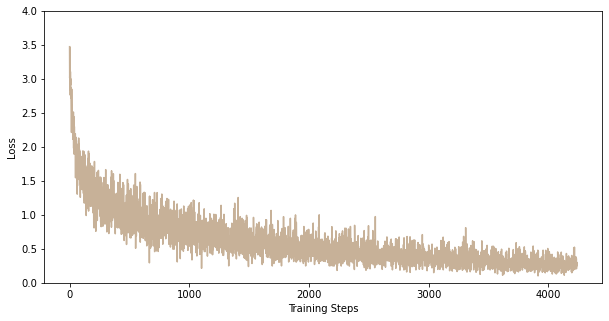

In [19]:
plt.figure(figsize=(10,5))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(batch_stats_callback.batch_losses, color = '#c7b198')

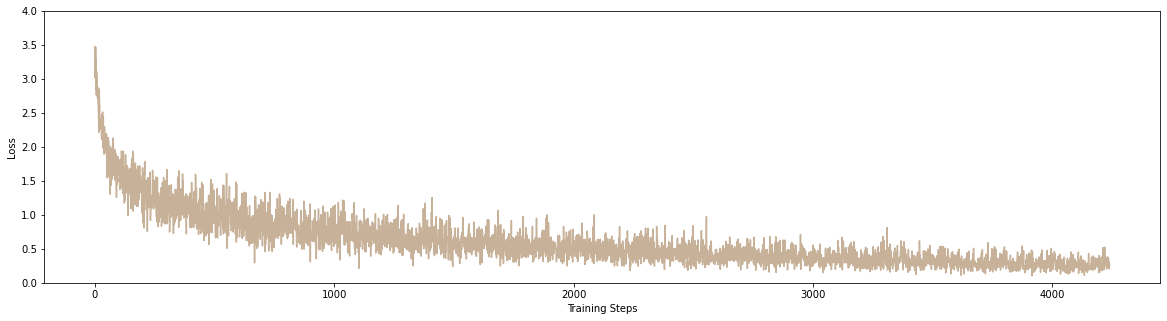

In [20]:
plt.figure(figsize=(20,5))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(batch_stats_callback.batch_losses, color = '#c7b198')

### 6. 정확도 확인

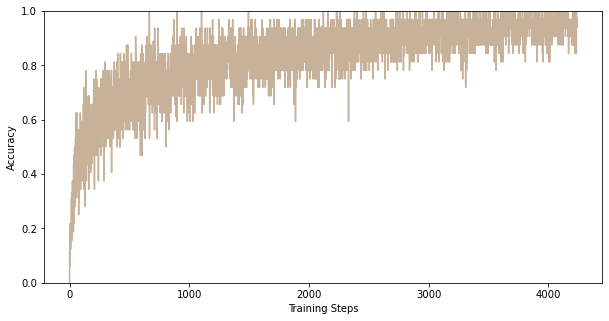

In [21]:
plt.figure(figsize=(10,5))
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc, color = '#c7b198')

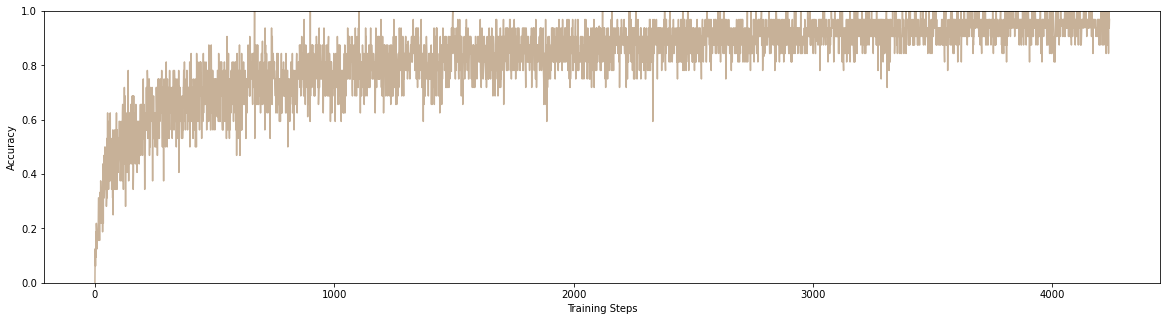

In [22]:
plt.figure(figsize=(20,5))
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc, color = '#c7b198')

### 7. 예측확인

In [23]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['갈비', '국물 떡볶이', '김밥', '김치찌개', '깐풍기', '꿔바로우', '된장찌개', '마라탕', '부대찌개',
       '불고기', '비빔밥', '삼겹살', '순두부찌개', '우동', '유산슬', '잡채', '족발', '짜장면', '짬뽕',
       '청국장'], dtype='<U6')

In [24]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [25]:
label_id = np.argmax(label_batch, axis=-1)

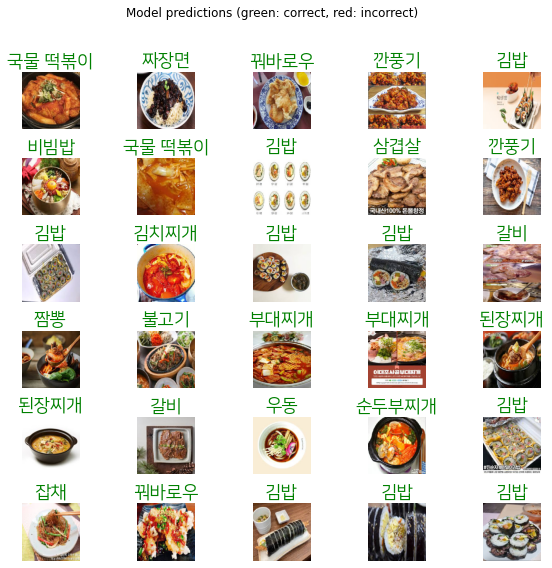

In [26]:
import matplotlib.font_manager as fm
font_path = r'C:\Users\jeongin\Downloads\NanumFontSetup_TTF_SQUARE\NanumSquareR.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), fontproperties=fontprop, color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### 8. 모델 내보내기

In [27]:
import time
t = time.time()

export_path = "/my_models/mobilenetv2_tl_findata20_{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /my_models/mobilenetv2_tl_findata20_1606301358\assets


INFO:tensorflow:Assets written to: /my_models/mobilenetv2_tl_findata20_1606301358\assets


'/my_models/mobilenetv2_tl_findata20_1606301358'

### 9. 저장된 모델 변환(tflite로)

In [31]:
import tensorflow as tf

saved_model_dir = export_path

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('mobilenetv2_tl_findata20.tflite', 'wb') as f:
  f.write(tflite_model)
